In [239]:
# the usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [109]:
X = pd.read_csv('./data/processed_first_X_17feat.csv')
y = pd.read_csv('./data/processed_first_y_17feat.csv')

In [110]:
train_df = X.copy()
train_df['diabetes'] = y
train_df.head()

,d1_glucose_max,glucose_apache,h1_glucose_max,h1_glucose_min,bmi,weight,d1_bun_max,bun_apache,d1_bun_min,d1_glucose_min,d1_creatinine_max,d1_creatinine_min,creatinine_apache,arf_apache,d1_potassium_max,age,diabetes
0,156.0,127.0,156.0,156.0,31.242126,77.5,12.0,12.0,12.0,127.0,0.70,0.70,0.70,0,4.8,75.0,0
1,175.0,118.0,140.0,134.0,20.976012,58.5,12.0,19.0,12.0,118.0,0.80,0.80,0.97,0,3.7,81.0,1
2,218.0,218.0,140.0,134.0,28.622530,80.4,7.0,7.0,7.0,129.0,0.68,0.68,0.68,0,4.0,60.0,1
3,97.0,97.0,140.0,134.0,23.474146,68.0,31.0,31.0,31.0,97.0,2.64,2.64,2.64,1,3.9,83.0,0
4,136.0,108.0,136.0,136.0,25.827271,70.4,20.0,20.0,20.0,108.0,1.20,1.20,1.20,0,4.2,74.0,0


In [ ]:
sns.pairplot(train_df[:,:10], hue='diabetes')

In [240]:
X_train, X_val, y_train, y_val = train_test_split(X.iloc[:,:10], y, test_size=0.20, random_state=18)

In [241]:
y_train = np.array(y_train).ravel()
y_val = np.array(y_val).ravel()

## Logistic Regression

### Baseline Score With 1 Feature: .798

In [242]:
X_train_1 = X_train[['d1_glucose_max']]
X_val_1 = X_val[['d1_glucose_max']]

In [127]:
# without regularization
lm1 = LogisticRegression(C=1000)
lm1.fit(X_train_1, y_train)

LogisticRegression(C=1000)

In [186]:
y_val_hat_1 = lm1.predict(X_val_1)

In [116]:
lm1.coef_, lm1.intercept_

(array([[0.01098291]]), array([-3.31716356]))

In [128]:
print(lm1.score(X_train_1, y_train))
print(lm1.score(X_val_1,y_val))

0.7984393757503001
0.7985594237695078


In [187]:
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_val_hat_1), 
                                                     recall_score(y_val, y_val_hat_1)))

Default threshold:
Precision: 0.5913,   Recall: 0.2115


In [205]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_hat_1 = (model.predict_proba(X_val_1)[:, 1] >= threshold)
    diabetes_confusion_1 = confusion_matrix(y_val, y_hat_1)
    plt.figure(dpi=150)
    sns.heatmap(diabetes_confusion_1, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['pred no', 'pred yes'],
           yticklabels=['actual no', 'actual yes']);
    plt.title('baseline confusion matrix')
    plt.savefig('./project-checkpoints/baseline_confusion.png')
    # plt.xlabel('prediction')
    # plt.ylabel('actual')

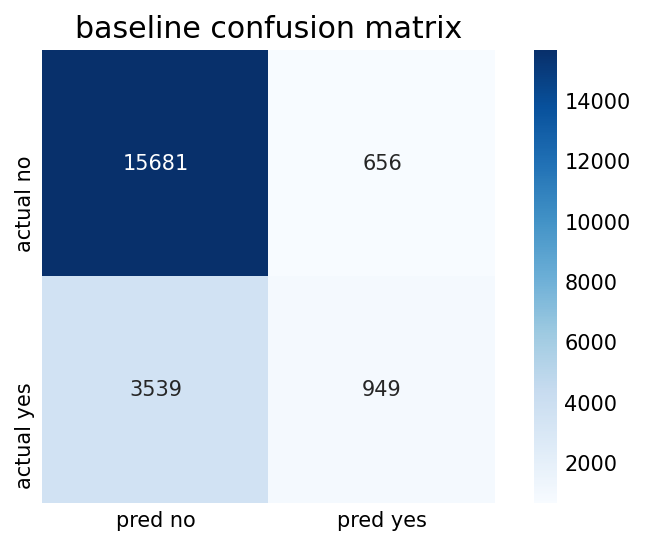

In [206]:
make_confusion_matrix(lm1)

### Score With 10 Features: .800

In [117]:
sts = StandardScaler()
sts.fit(X_train)

StandardScaler()

In [118]:
X_train_scale = sts.transform(X_train)
X_val_scale = sts.transform(X_val)

In [252]:
# with L2 regularization
lm10_l2 = LogisticRegression(C=10).fit(X_train_scale, y_train)

In [255]:
# with L1 regularization
lm10_l1 = LogisticRegression(C=10, solver='liblinear',penalty='l1').fit(X_train_scale, y_train)

In [257]:
yhat_l2_val = lm10_l2.predict(X_val_scale)
yhat_l1_val = lm10_l1.predict(X_val_scale)

In [214]:
feat10 = X_train.columns

In [224]:
list(zip(feat10,lm10.coef_[0,:]))

[('d1_glucose_max', 1.1608453715847986),
 ('glucose_apache', -0.17040029378887153),
 ('h1_glucose_max', -0.1157220962721568),
 ('h1_glucose_min', -0.0013602203806546745),
 ('bmi', 0.23617234042725896),
 ('weight', 0.1134195070599991),
 ('d1_bun_max', -0.18761613713336103),
 ('bun_apache', -0.06757987333161064),
 ('d1_bun_min', 0.43205846927449365),
 ('d1_glucose_min', -0.06156014158605123)]

In [258]:
print('Train Score (L2): ',lm10_l2.score(X_train_scale, y_train))
print('Val Score (L2): ',lm10_l2.score(X_val_scale,y_val))
print('Train Score (L1): ',lm10_l1.score(X_train_scale, y_train))
print('Val Score (L1): ',lm10_l1.score(X_val_scale,y_val))

Train Score (L2):  0.8005282112845138
Val Score (L2):  0.8004801920768307
Train Score (L1):  0.8005522208883553
Val Score (L1):  0.8005282112845138


In [259]:
print("L2 Regularization:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, yhat_l2_val), 
                                                     recall_score(y_val, yhat_l2_val)))

print("L1 Regularization:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, yhat_l1_val), 
                                                     recall_score(y_val, yhat_l1_val)))

L2 Regularization:
Precision: 0.5898,   Recall: 0.2438
L1 Regularization:
Precision: 0.5900,   Recall: 0.2440


In [207]:
def make_confusion_matrix_10(model, threshold=0.5):
    y_hat = (model.predict_proba(X_val_scale)[:, 1] >= threshold)
    diabetes_confusion = confusion_matrix(y_val, y_hat)
    
    plt.figure(dpi=150)
    sns.heatmap(diabetes_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['pred no', 'pred yes'],
           yticklabels=['actual no', 'actual yes']);
    plt.title('10 feature confusion matrix')
    plt.savefig('./project-checkpoints/tenfeat_confusion.png')
    
    # plt.xlabel('prediction')
    # plt.ylabel('actual')

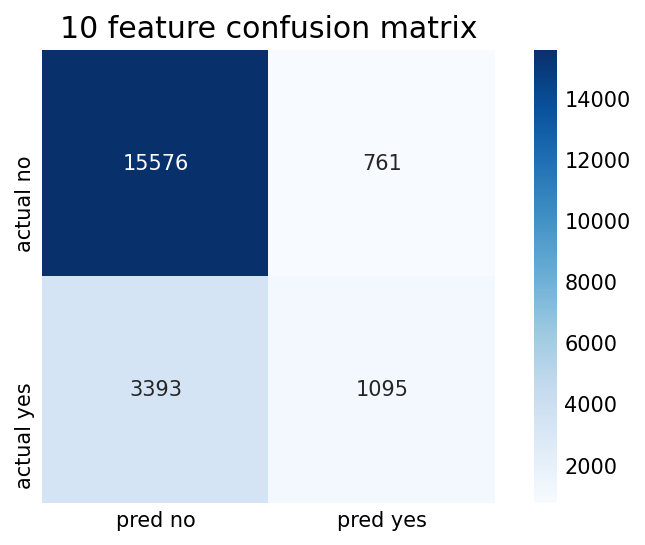

In [260]:
make_confusion_matrix_10(lm10_l1)

## Random Forest

In [237]:
rf = RandomForestClassifier(n_estimators=15)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=15)

In [238]:
print(rf.score(X_train,y_train))
print(rf.score(X_val,y_val))

0.9937214885954382
0.7938535414165666


In [234]:
list(zip(feat10,rf.feature_importances_))

[('d1_glucose_max', 0.17927866345679758),
 ('glucose_apache', 0.1455524813780786),
 ('h1_glucose_max', 0.0696434516996261),
 ('h1_glucose_min', 0.05946331033689133),
 ('bmi', 0.13255501528292),
 ('weight', 0.11909663631730778),
 ('d1_bun_max', 0.06415810706126973),
 ('bun_apache', 0.06024067054947462),
 ('d1_bun_min', 0.06859610017390706),
 ('d1_glucose_min', 0.10141556374372718)]